KN-414 

Maksymets Vira


6. Побудувати CNN на основі ResNet-50 для класифікації зображень на основі
датасету fashion-mnist.

Зробити налаштування моделі для досягнення необхідної точності.

 На базі
Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

## 1. Prepare dataset

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import keras
from keras import layers, models, utils

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1) / 255
x_test = x_test.reshape(-1, 28, 28, 1) / 255

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [ ]:
classes = np.unique(y_train)
num_classes = len(classes)

classes, num_classes

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), 10)

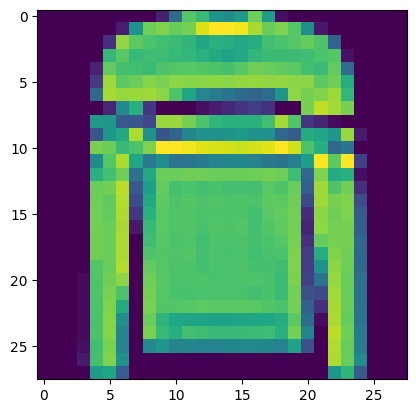

In [ ]:
plt.imshow(x_train[5])

## 3. Define model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Add, BatchNormalization, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# a residual block that is used when the dimensions of the input tensor and output tensor do not match
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """
    Convolution block to be used in ResNet50.
    """
    filters1, filters2, filters3 = filters
    if strides == (2, 2):
        name_base = 'res' + str(stage) + block + '_'
    else:
        name_base = 'identity' + str(stage) + block + '_'

    # First convolutional layer
    x = Conv2D(filters1, (1, 1), strides=strides, name=name_base + '2a')(input_tensor)
    x = BatchNormalization(name=name_base + 'bn2a')(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters2, kernel_size, padding='same', name=name_base + '2b')(x)
    x = BatchNormalization(name=name_base + 'bn2b')(x)
    x = Activation('relu')(x)

    # Third convolutional layer
    x = Conv2D(filters3, (1, 1), name=name_base + '2c')(x)
    x = BatchNormalization(name=name_base + 'bn2c')(x)

    # Shortcut connection
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=name_base + 'bn1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# is used when the input tensor and the output tensor have the same dimensions. 
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    Identity block to be used in ResNet50.
    """
    filters1, filters2, filters3 = filters
    name_base = 'res' + str(stage) + block + '_'

    # First convolutional layer
    x = Conv2D(filters1, (1, 1), name=name_base + '2a')(input_tensor)
    x = BatchNormalization(name=name_base + 'bn2a')(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters2, kernel_size, padding='same', name=name_base + '2b')(x)
    x = BatchNormalization(name=name_base + 'bn2b')(x)
    x = Activation('relu')(x)

    # Third convolutional layer
    x = Conv2D(filters3, (1, 1), name=name_base + '2c')(x)
    x = BatchNormalization(name=name_base + 'bn2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [ ]:

def ResNet50Own(input_shape=(28,28,1), classes=10):
    """
    Implementation of the ResNet50 architecture.
    """
    # Input layer
    inputs = Input(input_shape)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # Average pooling layer
    x = GlobalAveragePooling2D(name='avg_pool')(x)

    # Output layer
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='output')(x)

    # Create the model
    model = Model(inputs, x, name='resnet50')
    return model


In [ ]:
model = ResNet50Own(input_shape=(28,28,1), classes=10)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 14, 14, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 activation_49 (Activation)     (None, 14, 14, 64)   0           ['bn_conv1[0][0]']               
                                                                                           

## 5. Train

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [ ]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

In [ ]:
with tf.device('/device:GPU:0'):
    model.compile(
      optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(
      x_train,
      y_train,
      batch_size=256,
      epochs=10,
      validation_data=(x_test, y_test),
      shuffle=True,
      )

Epoch 1/10
235/235 [==============================] - 88s 95ms/step - loss: 0.6091 - accuracy: 0.7899 - val_loss: 2.0793 - val_accuracy: 0.2539
Epoch 2/10
235/235 [==============================] - 19s 82ms/step - loss: 0.3507 - accuracy: 0.8705 - val_loss: 0.9581 - val_accuracy: 0.6620
Epoch 3/10
235/235 [==============================] - 23s 99ms/step - loss: 0.2849 - accuracy: 0.8947 - val_loss: 0.4354 - val_accuracy: 0.8490
Epoch 4/10
235/235 [==============================] - 21s 89ms/step - loss: 0.2508 - accuracy: 0.9064 - val_loss: 0.3602 - val_accuracy: 0.8724
Epoch 5/10
235/235 [==============================] - 22s 92ms/step - loss: 0.2275 - accuracy: 0.9162 - val_loss: 0.3921 - val_accuracy: 0.8672
Epoch 6/10
235/235 [==============================] - 25s 105ms/step - loss: 0.2055 - accuracy: 0.9239 - val_loss: 0.4273 - val_accuracy: 0.8625
Epoch 7/10
235/235 [==============================] - 25s 104ms/step - loss: 0.1947 - accuracy: 0.9269 - val_loss: 0.4326 - val_accurac

## Show accuracy

In [ ]:
acc = model.evaluate(x_test, y_test)
acc

313/313 [==============================] - 4s 10ms/step - loss: 0.3833 - accuracy: 0.8835


[0.3833409547805786, 0.8834999799728394]

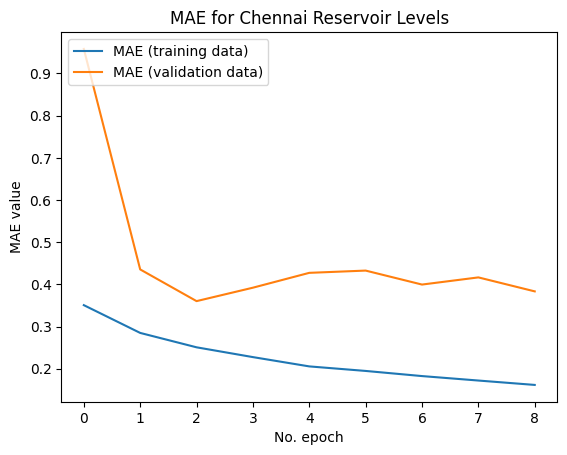

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'][1:], label='MAE (training data)')
plt.plot(history.history['val_loss'][1:], label='MAE (validation data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# **Similarity Model**

In [ ]:
train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_train)]
print("train groups:", [x[0].shape for x in train_groups])
     

train groups: [(28, 28, 1), (28, 28, 1), (28, 28, 1), (28, 28, 1), (28, 28, 1), (28, 28, 1), (28, 28, 1), (28, 28, 1), (28, 28, 1), (28, 28, 1)]


In [ ]:
features_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output, name='FeatureExtractor')
features_model.summary()

Model: "FeatureExtractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 14, 14, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 activation_49 (Activation)     (None, 14, 14, 64)   0           ['bn_conv1[0][0]']               
                                                                                   

In [ ]:
from keras.layers import concatenate

img_a_in = layers.Input(shape=x_train.shape[1:], name="ImageA_Input")
img_b_in = layers.Input(shape=x_train.shape[1:], name="ImageB_Input")
img_a_feat = features_model(img_a_in)
img_b_feat = features_model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name="merge_features")
combined_features = layers.Dense(256, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(128, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(1, activation="sigmoid")(combined_features)
similarity_model = models.Model(
    inputs=[img_a_in, img_b_in], outputs=[combined_features], name="SimilarityModel"
)
similarity_model.summary()

Model: "SimilarityModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureExtractor (Functional)  (None, 2048)         23581440    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 4096)         0           ['FeatureExtractor[

In [ ]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

# **Model output**

In [ ]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in group_idx
        ]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [
                np.random.choice([i for i in all_groups if i != c_idx])
                for c_idx in group_idx
            ]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in b_group_idx
        ]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

1/1 [==============================] - 3s 3s/step


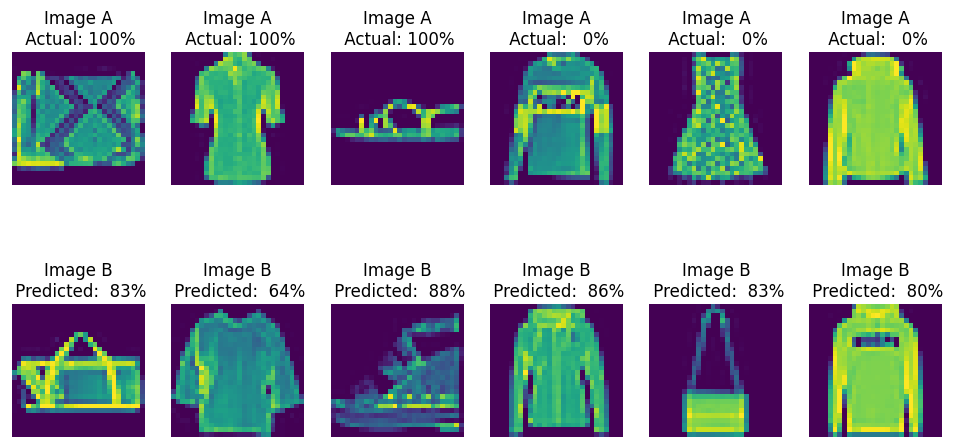

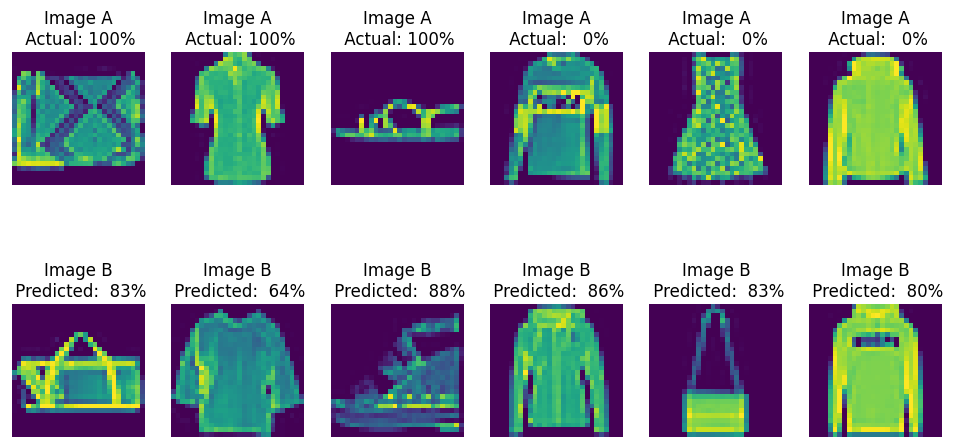

In [ ]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title("Image A\n Actual: %3.0f%%" % (100 * c_d))
        ax1.axis("off")
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title("Image B\n Predicted: %3.0f%%" % (100 * p_d))
        ax2.axis("off")
    return fig


show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10


<ipython-input-29-db6e8c2a5a62>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(


500/500 [==============================] - 112s 108ms/step - loss: 0.4612 - mae: 0.3004 - val_loss: 0.3878 - val_mae: 0.2545
Epoch 2/10
500/500 [==============================] - 62s 124ms/step - loss: 0.3549 - mae: 0.2250 - val_loss: 0.3695 - val_mae: 0.2240
Epoch 3/10
500/500 [==============================] - 61s 122ms/step - loss: 0.3271 - mae: 0.2048 - val_loss: 0.3078 - val_mae: 0.1788
Epoch 4/10
500/500 [==============================] - 54s 108ms/step - loss: 0.3007 - mae: 0.1878 - val_loss: 0.2786 - val_mae: 0.1711
Epoch 5/10
500/500 [==============================] - 59s 118ms/step - loss: 0.2849 - mae: 0.1767 - val_loss: 0.2864 - val_mae: 0.1749
Epoch 6/10
500/500 [==============================] - 58s 115ms/step - loss: 0.2724 - mae: 0.1675 - val_loss: 0.2715 - val_mae: 0.1676
Epoch 7/10
500/500 [==============================] - 65s 130ms/step - loss: 0.2672 - mae: 0.1641 - val_loss: 0.2497 - val_mae: 0.1415
Epoch 8/10
500/500 [==============================] - 53s 106ms/s

In [ ]:
x_test_features = features_model.predict(x_test, verbose=True, batch_size=256)

40/40 [==============================] - 4s 21ms/step


In [ ]:
x_test_features

array([[0.        , 0.5854398 , 0.61631787, ..., 0.27383858, 0.7654011 ,
        0.5160906 ],
       [0.57883734, 0.18277252, 3.0500546 , ..., 0.9088644 , 0.        ,
        1.57005   ],
       [4.6179357 , 2.4693892 , 0.        , ..., 2.7775826 , 8.168987  ,
        0.        ],
       ...,
       [0.        , 0.        , 2.2440546 , ..., 0.        , 0.        ,
        3.060636  ],
       [4.9495773 , 2.6141853 , 0.        , ..., 2.9890318 , 8.696358  ,
        0.        ],
       [0.        , 0.        , 0.55598366, ..., 0.        , 0.        ,
        2.7438247 ]], dtype=float32)

# **PCA + TSNE**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca_result = pca.fit_transform(x_test_features)
print('Cumulative explained variation for 40 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 40 principal components: 0.9998248219490051


In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, init="pca")

tsne_result = tsne.fit_transform(pca_result)

tsne_result.shape

(10000, 2)

In [ ]:
categ = {
    1:"T-shirt/top",
    2:"Trouser",
    3:"Pullover",
    4:"Dress",
    5:"Coat",
    6:"Sandal",
    7:"Shirt",
    8:"Sneaker",
    9:"Bag",
    10:"Ankle boot",
}

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_test})
tsne_result_df.label = tsne_result_df.label + 1
tsne_result_df['label'] = [categ.get(x) for x in tsne_result_df['label']]

tsne_result_df.head()

,tsne_1,tsne_2,label
0,12.010969,60.479748,Ankle boot
1,-45.456718,-78.642242,Pullover
2,90.655426,-16.075098,Trouser
3,86.444305,-18.822903,Trouser
4,-23.370838,-0.750883,Shirt


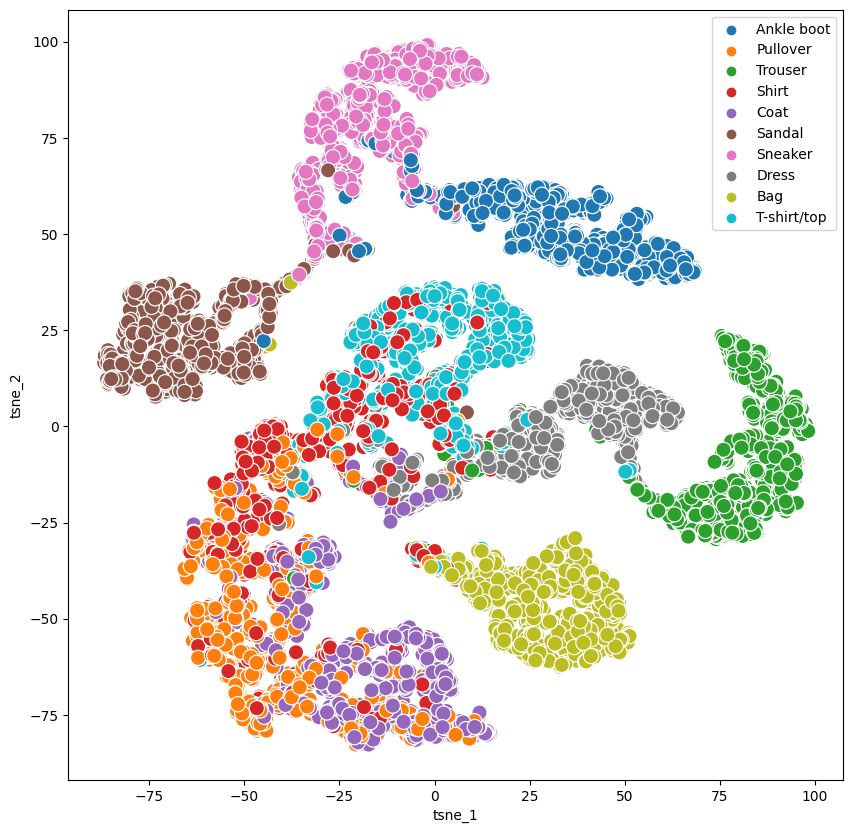

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120)
ax.legend()